In [16]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='white'
plt.rcParams['axes.edgecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

Load the PDBbind training set.

In [17]:
pdbbind_training_set_pk = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_training_set = pdbbind_training_set_pk.index

docked_pose_features = pd.read_csv('../data/docked_pose_features.csv', index_col=0)

# We only want the pose ranked highest by Smina
pdbbind_training_set_labels = pdbbind_training_set.map(lambda x: x+'_0')
pdbbind_training_set_features = docked_pose_features.loc[pdbbind_training_set_labels]
pdbbind_training_set_features.rename(index=lambda x: x[:4], inplace=True)


feature_sets = {}
with open('../data/lb_feature_names.txt') as f:
    feature_sets['LB'] = pd.Index([l.strip() for l in f])
with open('../data/sb_feature_names.txt') as f:
    feature_sets['SB'] = pd.Index([l.strip() for l in f])
with open('../data/hb_feature_names.txt') as f:
    feature_sets['HB'] = pd.Index([l.strip() for l in f])

Load the updated DUD-E diverse set.

In [18]:
targets = ['AKT1', 'CP3A4', 'GCR', 'HIVPR', 'HIVRT', 'KIF11']
docked_features = {}
ligand_features = {}
for target in targets:
    with open(f'../data/{target}_KI_docked_features.json') as f:
        docked_features[target] = json.load(f)
    with open(f'../data/{target}_KI_rdkit_descriptors.json') as f:
        ligand_features[target] = json.load(f)

# Concatenate structure-based and ligand-based features
features = {}
for target in targets:
    features[target] = {}
    for label in docked_features[target]:
        features[target][label] = {**docked_features[target][label], **ligand_features[target][label.split('_')[0]]}
features = {target: pd.DataFrame(features[target]).T for target in features}

In [19]:
dude_pk = {}
for target in targets:
    df = pd.read_csv(f'../data/{target}_KI_clean.csv', index_col=0)
    dude_pk[target] = df['pChEMBL Value']

### Distribution of binding data

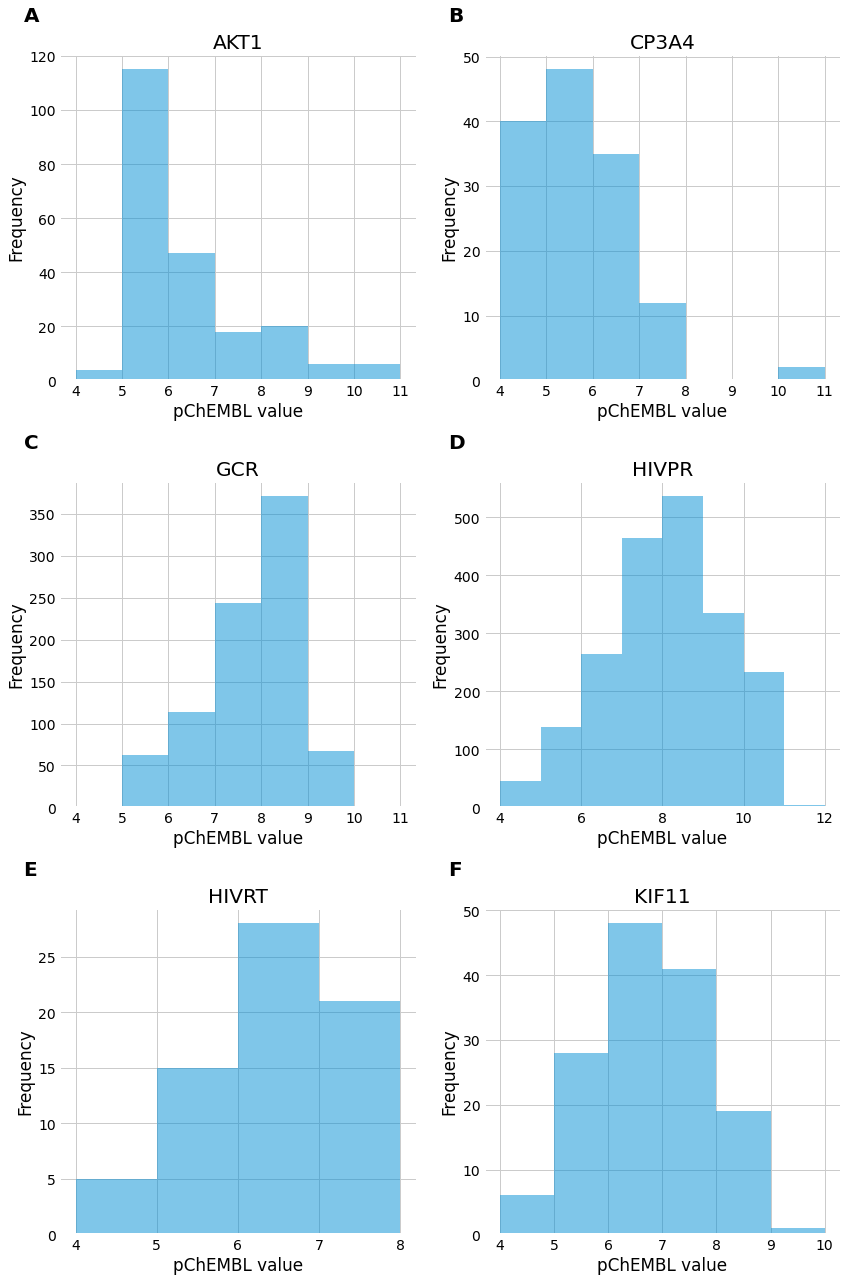

In [21]:
fig, axes = plt.subplots(3,2,figsize=(12, 18))
axes = axes.flatten()
annots = iter(['A', 'B', 'C', 'D', 'E', 'F'])
for target, ax in zip(targets, axes):
    data = dude_pk[target].values.ravel()
    xmin = int(min(data))
    xmax = int(max(data))+1
    ax.hist(data, bins=np.arange(xmin, xmax+1, 1), alpha=0.5)
    ax.set_title(target)
    ax.text(-0.1, 1.1, next(annots), transform=ax.transAxes, size=20, weight='bold')
    ax.set_xlabel('pChEMBL value')
    ax.set_ylabel('Frequency')
fig.tight_layout()
fig.savefig('../figures/chembl_data_distribution.png', dpi=350, bbox_inches='tight')

Get the labels of the pose ranked highest by Smina for each ligand.

In [6]:
base_ids = {}
conformer_ids = {}
for target in targets:
    labels = features[target].index
    base_ids[target] = []
    conformer_ids[target] = {}
    for label in labels:
        base_id = label.split('_')[0]
        if base_id in conformer_ids[target]:
            conformer_ids[target][base_id].append(label)
        else:
            conformer_ids[target][base_id] = [label]

dude_top_docked_poses = {}

for target in targets:
    dude_top_docked_poses[target] = pd.Index([conformer_ids[target][base_id][0] for base_id in conformer_ids[target]])

### PDBbind training set

First train on the PDBbind training set and test on each of the DUD-E diverse targets.

In [7]:

predicted = {}

for f in feature_sets:
    predicted[f] = {}
    X_train = pdbbind_training_set_features.loc[pdbbind_training_set, feature_sets[f]].values
    y_train = pdbbind_training_set_pk.loc[pdbbind_training_set].values.ravel()
    rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
    rf.fit(X_train, y_train)

    for t in targets:
        X_test = features[t].loc[:, feature_sets[f]]
        pred = rf.predict(X_test)
        predicted[f][t] = {key: value for key, value in zip(X_test.index, pred)}

with open('../results/pdbbind_training_set_dude_predictions.json', 'w') as f:
    json.dump(predicted, f)

In [8]:
max_score = {}

for f in feature_sets:
    max_score[f] = {}
    
    for t in targets:
        
        max_score[f][t] = {}
        
        for key in predicted[f][t]:
            
            value = predicted[f][t][key]
            key = key.split('_')[0]
            if key not in max_score[f][t]:
                max_score[f][t][key] = value
            else:
                if value > max_score[f][t][key]:
                    max_score[f][t][key] = value
                    
        max_score[f][t] = pd.Series(max_score[f][t])

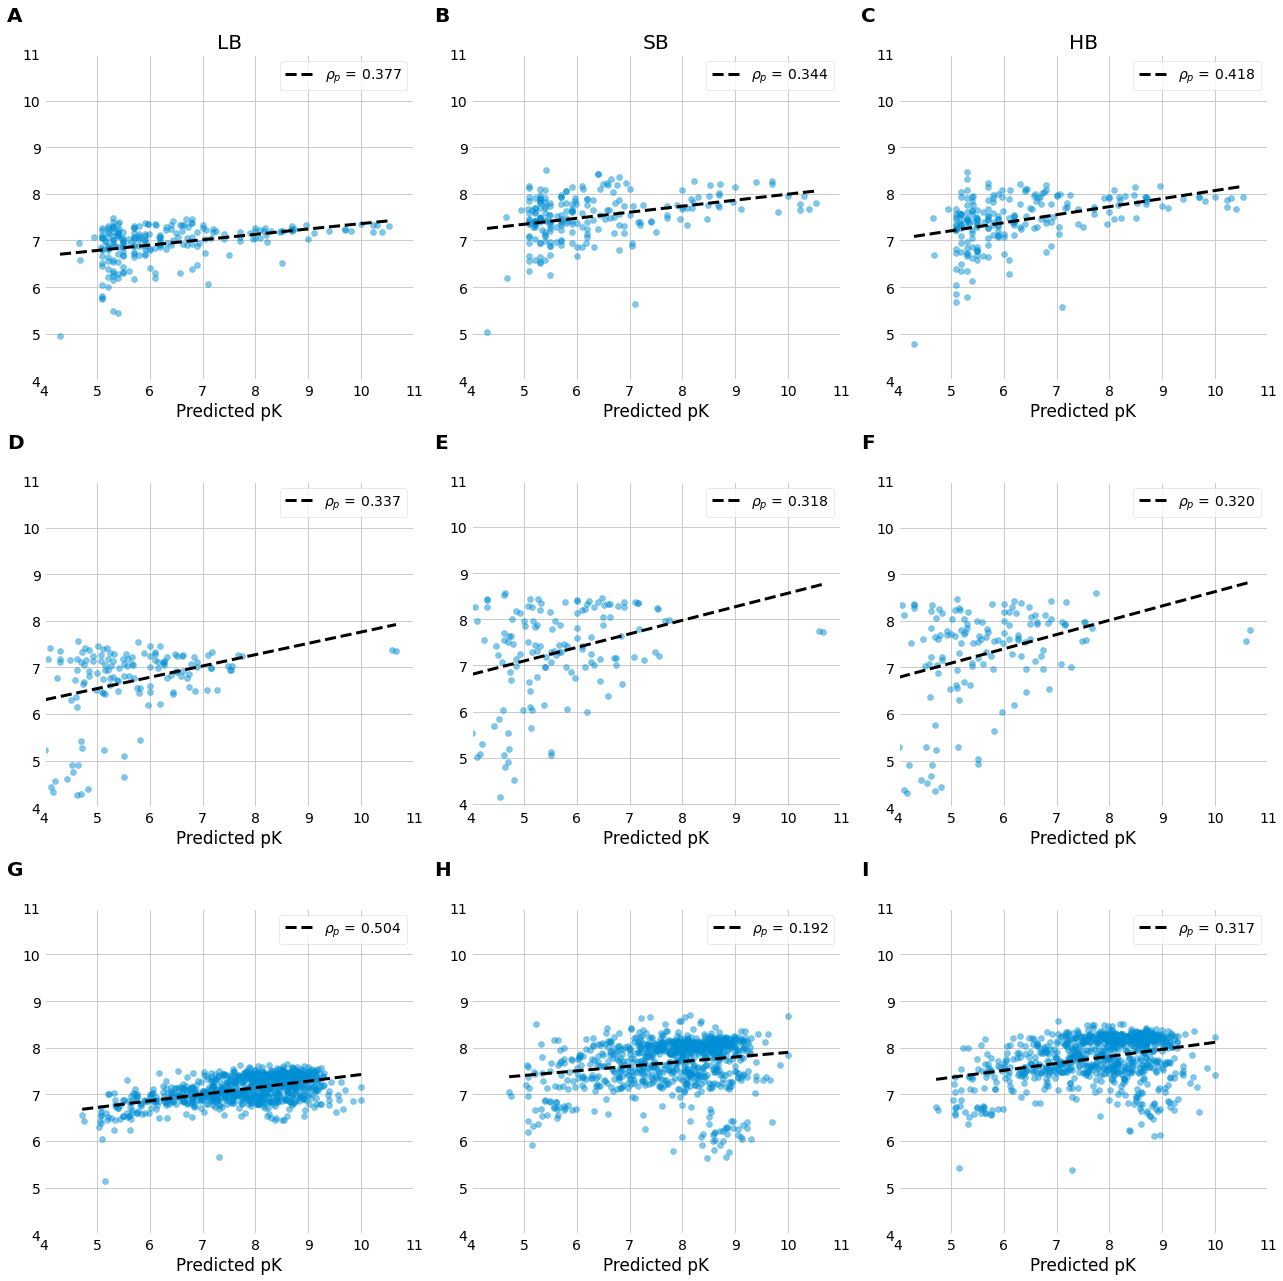

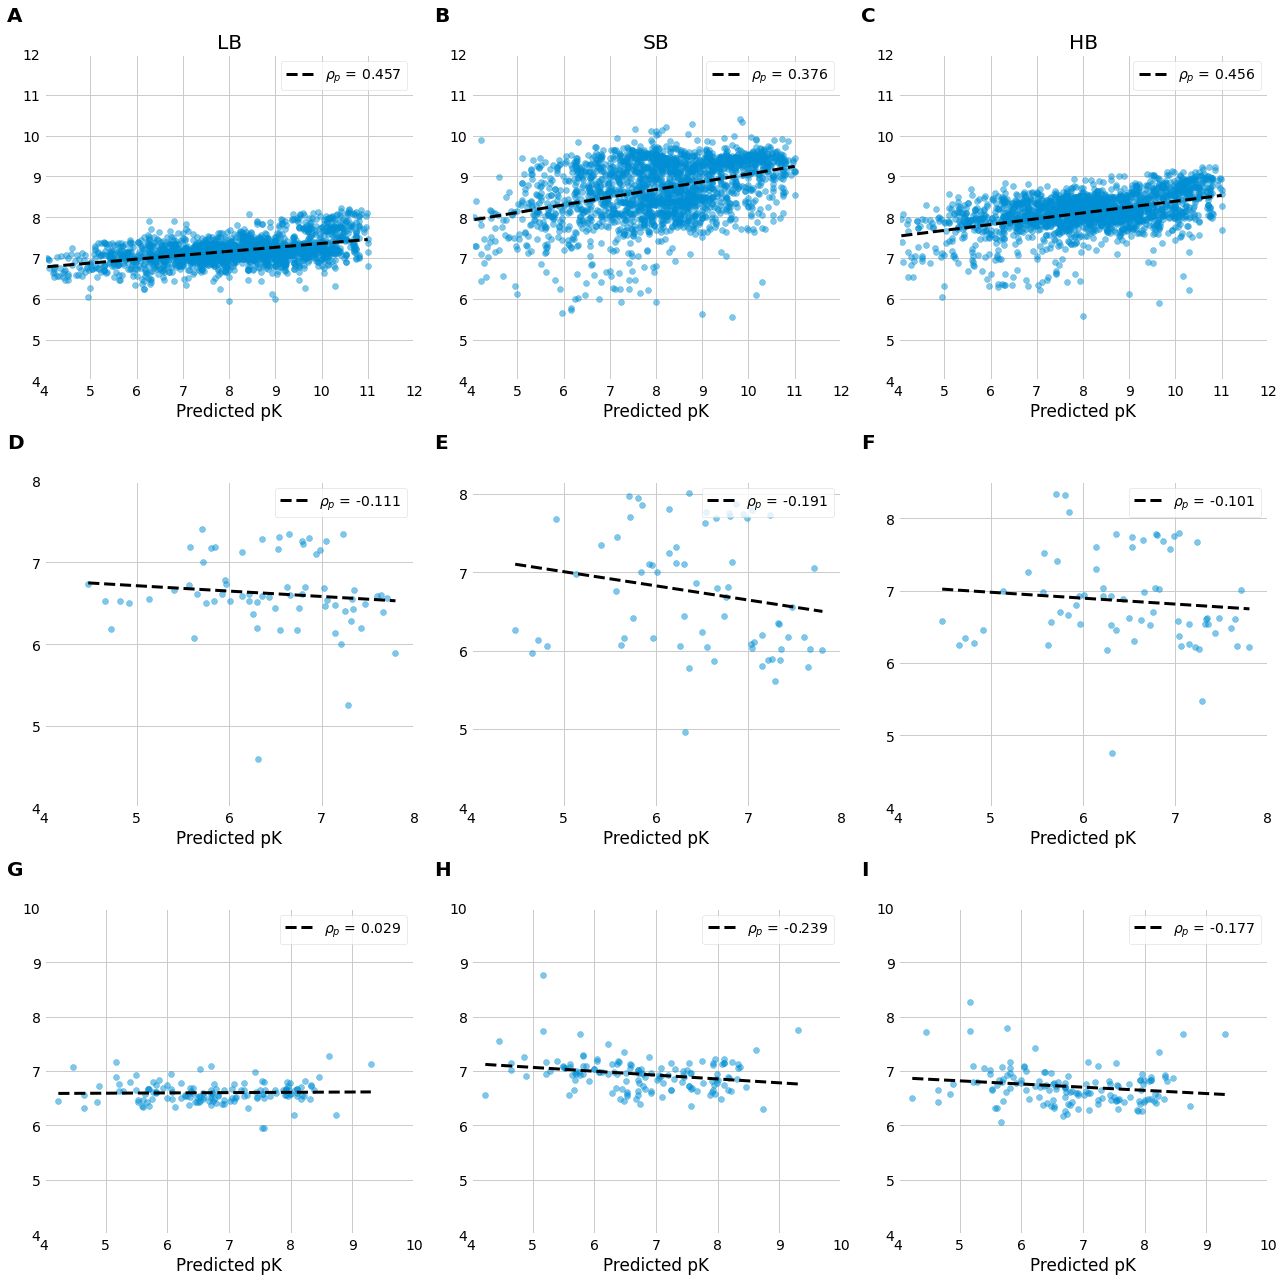

In [9]:
annotations = [['A', 'B', 'C'], ['D', 'E', 'F'], ['G', 'H', 'I']]

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[:3], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[max_score[f][target].index]
        y_pred = max_score[f][target]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel('Measured pK')
        ax.set_xlabel('Predicted pK')
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)

fig.tight_layout()
fig.savefig('../figures/dude_chembl_trained_on_pdbbind_1.png', dpi=350, bbox_inches='tight')

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[3:], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[max_score[f][target].index]
        y_pred = max_score[f][target]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel('Measured pK')
        ax.set_xlabel('Predicted pK')
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)
fig.tight_layout()
fig.savefig('../figures/dude_chembl_trained_on_pdbbind_2.png', dpi=350, bbox_inches='tight')

### Inter-target validation

In [10]:
inter_target_pred = {}
for target in targets:
    inter_target_pred[target] = {}
    training_targets = [t for t in targets if t != target]
    
    X_train = []
    y_train = []
    for t in training_targets:
        X = features[t].loc[dude_top_docked_poses[t]]
        idx = pd.Index([i.split('_')[0] for i in X.index])
        X.index = idx
        y = dude_pk[t].loc[idx]
        X_train.append(X)
        y_train.append(y)
    X_train = pd.concat(X_train, axis='index')
    y_train = pd.concat(y_train, axis='index')
    
    for f in feature_sets:
        rf= RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train.loc[:, feature_sets[f]], y_train)

        X_test = features[target].loc[:, feature_sets[f]]
        inter_target_pred[target][f] = pd.Series(index=X_test.index, data=rf.predict(X_test))

In [11]:
inter_target_max_score = {}
for target in targets:
    inter_target_max_score[target] = {}
    for f in feature_sets:
        scores = [inter_target_pred[target][f].loc[conformer_ids[target][base_id]].max() for base_id in conformer_ids[target]]
        inter_target_max_score[target][f] = pd.Series(data=scores, index=conformer_ids[target])

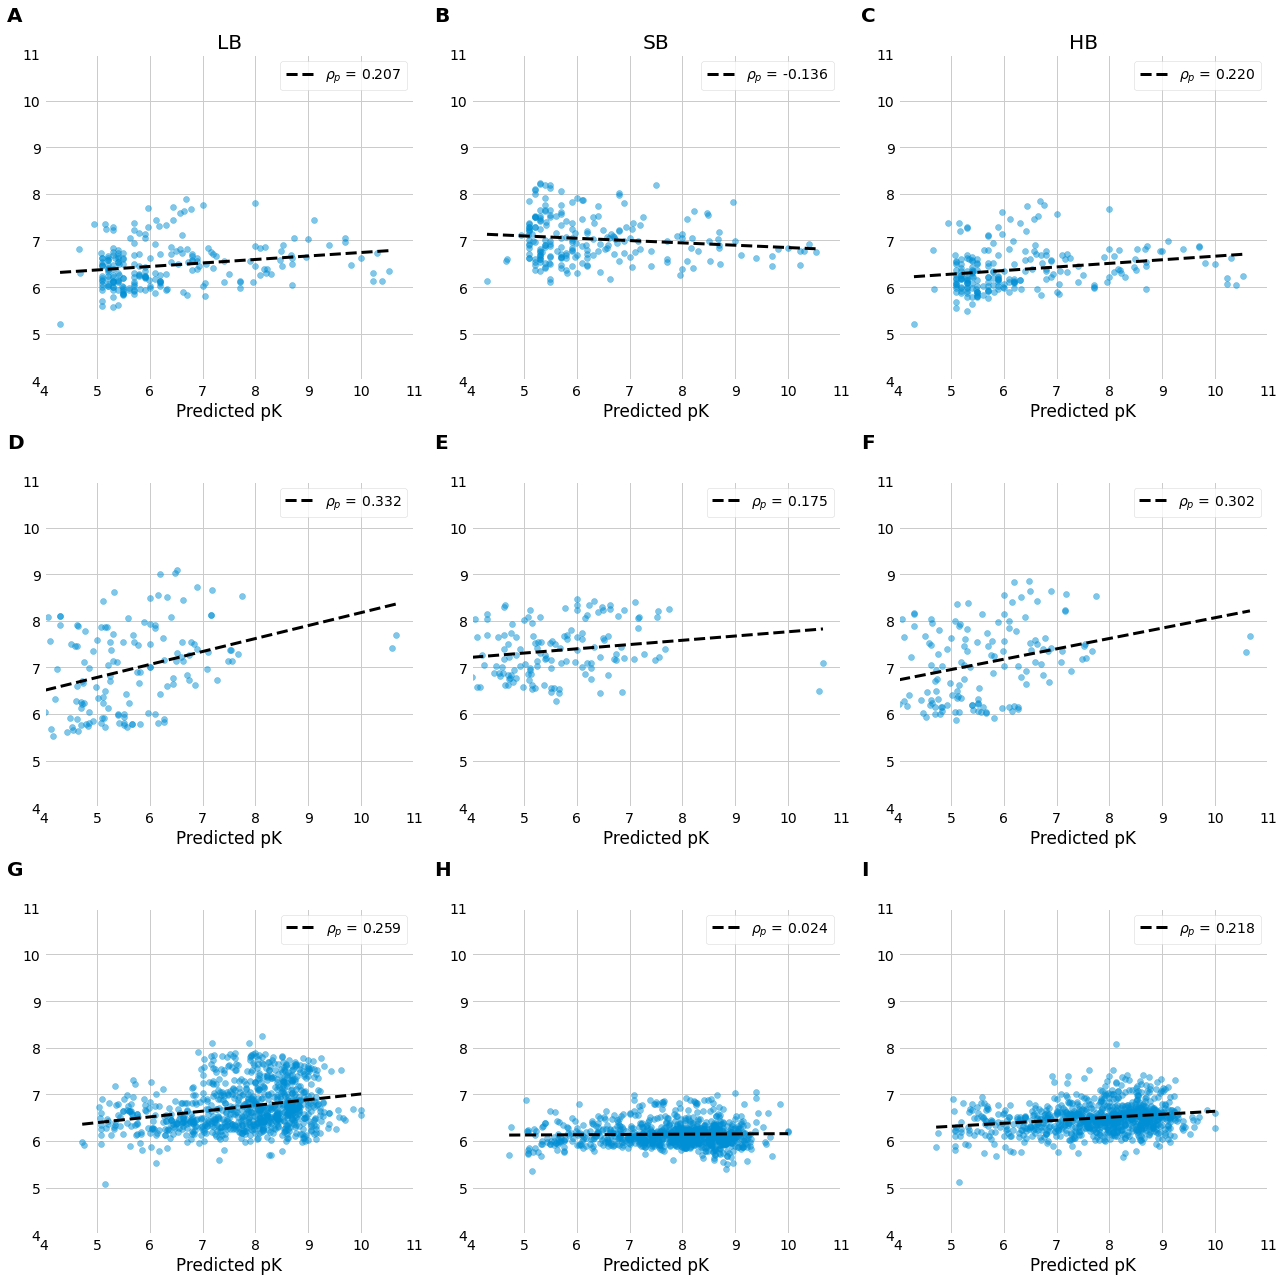

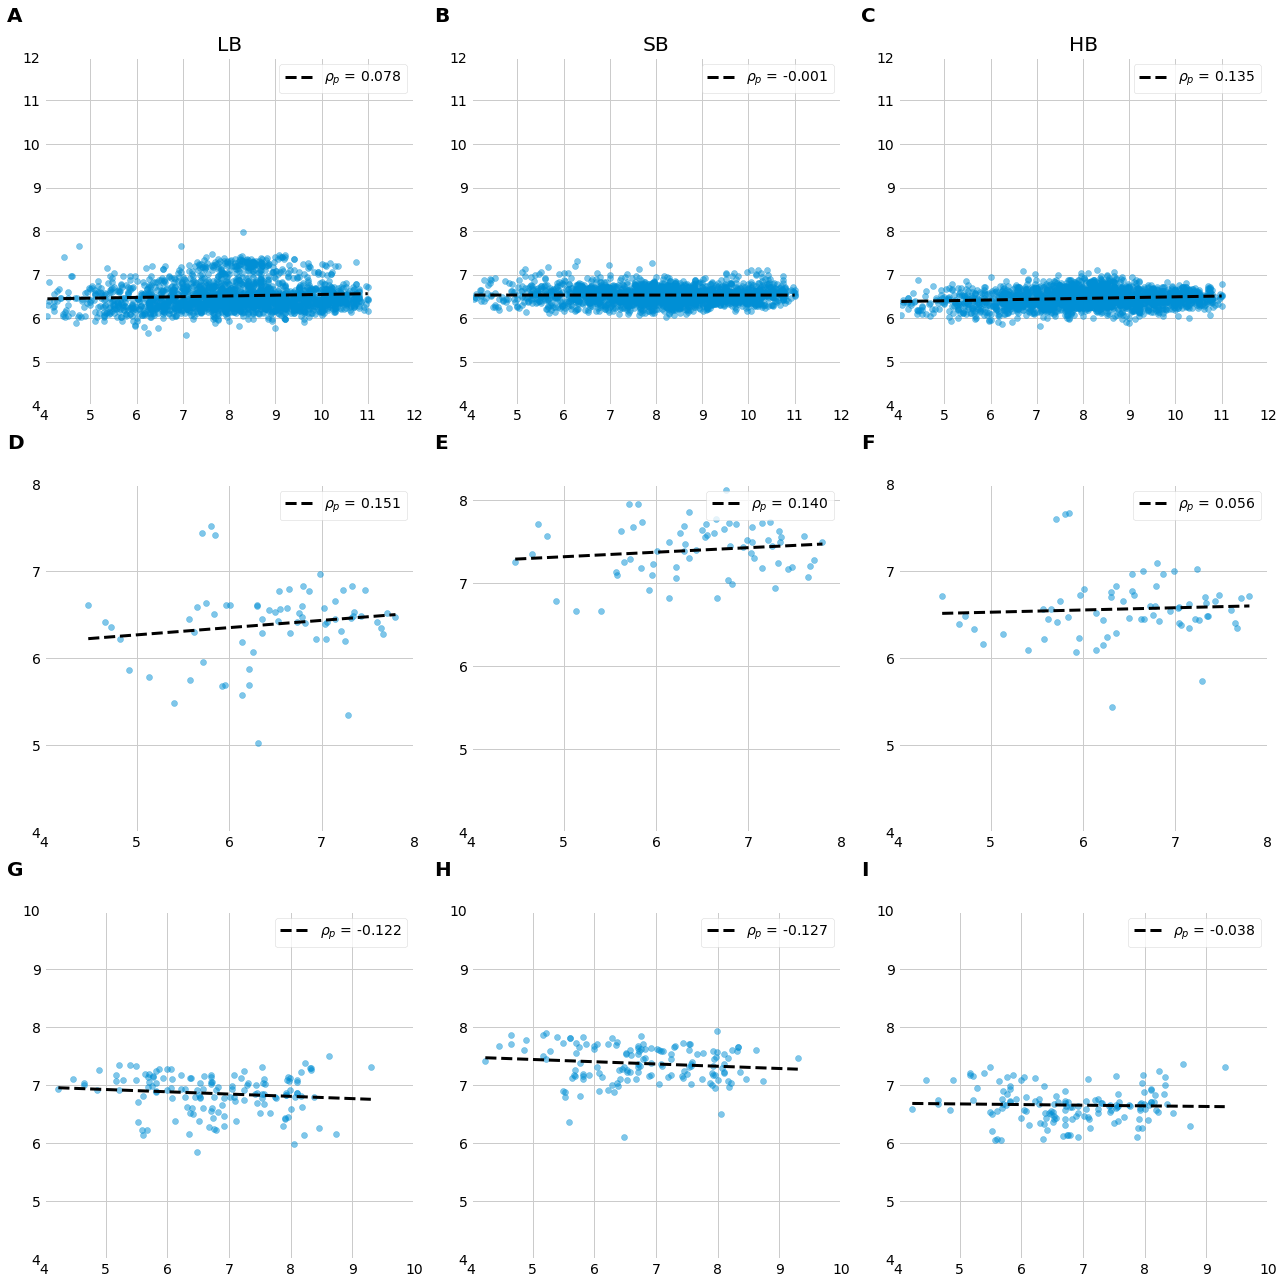

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[:3], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[inter_target_max_score[target][f].index]
        y_pred = inter_target_max_score[target][f]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel('Measured pK')
        ax.set_xlabel('Predicted pK')
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)

fig.tight_layout()
fig.savefig('../figures/dude_chembl_leave_target_out_1.png', dpi=350, bbox_inches='tight')

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[3:], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[inter_target_max_score[target][f].index]
        y_pred = inter_target_max_score[target][f]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)

fig.tight_layout()
fig.savefig('../figures/dude_chembl_leave_target_out_2.png', dpi=350, bbox_inches='tight')

### Intra-target validation

In [13]:
np.random.seed(42)

intra_target_pred = {}

intra_target_training_sets = {}
intra_target_test_sets = {}

for target in targets:
    intra_target_pred[target] = {}
    
    idx = list(conformer_ids[target])
    n_train = int(0.8*len(idx))
    train = np.random.choice(idx, size=n_train, replace=False)
    test = [i for i in idx if i not in train]
    
    intra_target_training_sets[target] = train
    intra_target_test_sets[target] = test
        
    for f in feature_sets:
        train_idx = [conformer_ids[target][i][0] for i in train]
        test_idx = [conf for i in test for conf in conformer_ids[target][i]]
        
        X_train = features[target].loc[train_idx, feature_sets[f]]
        y_train = dude_pk[target].loc[train]
        
        X_test = features[target].loc[test_idx, feature_sets[f]]
    
        rf= RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=6)
        rf.fit(X_train, y_train)

        intra_target_pred[target][f] = pd.Series(index=X_test.index, data=rf.predict(X_test))
        scores = [intra_target_pred[target][f].loc[conformer_ids[target][base_id]].max() for base_id in intra_target_test_sets[target]]
        max_scores = pd.Series(data=scores, index=intra_target_test_sets[target])

In [14]:
intra_target_max_score = {}
for target in targets:
    intra_target_max_score[target] = {}
    for f in feature_sets:
        scores = [intra_target_pred[target][f].loc[conformer_ids[target][base_id]].max() for base_id in intra_target_test_sets[target]]
        intra_target_max_score[target][f] = pd.Series(data=scores, index=intra_target_test_sets[target])

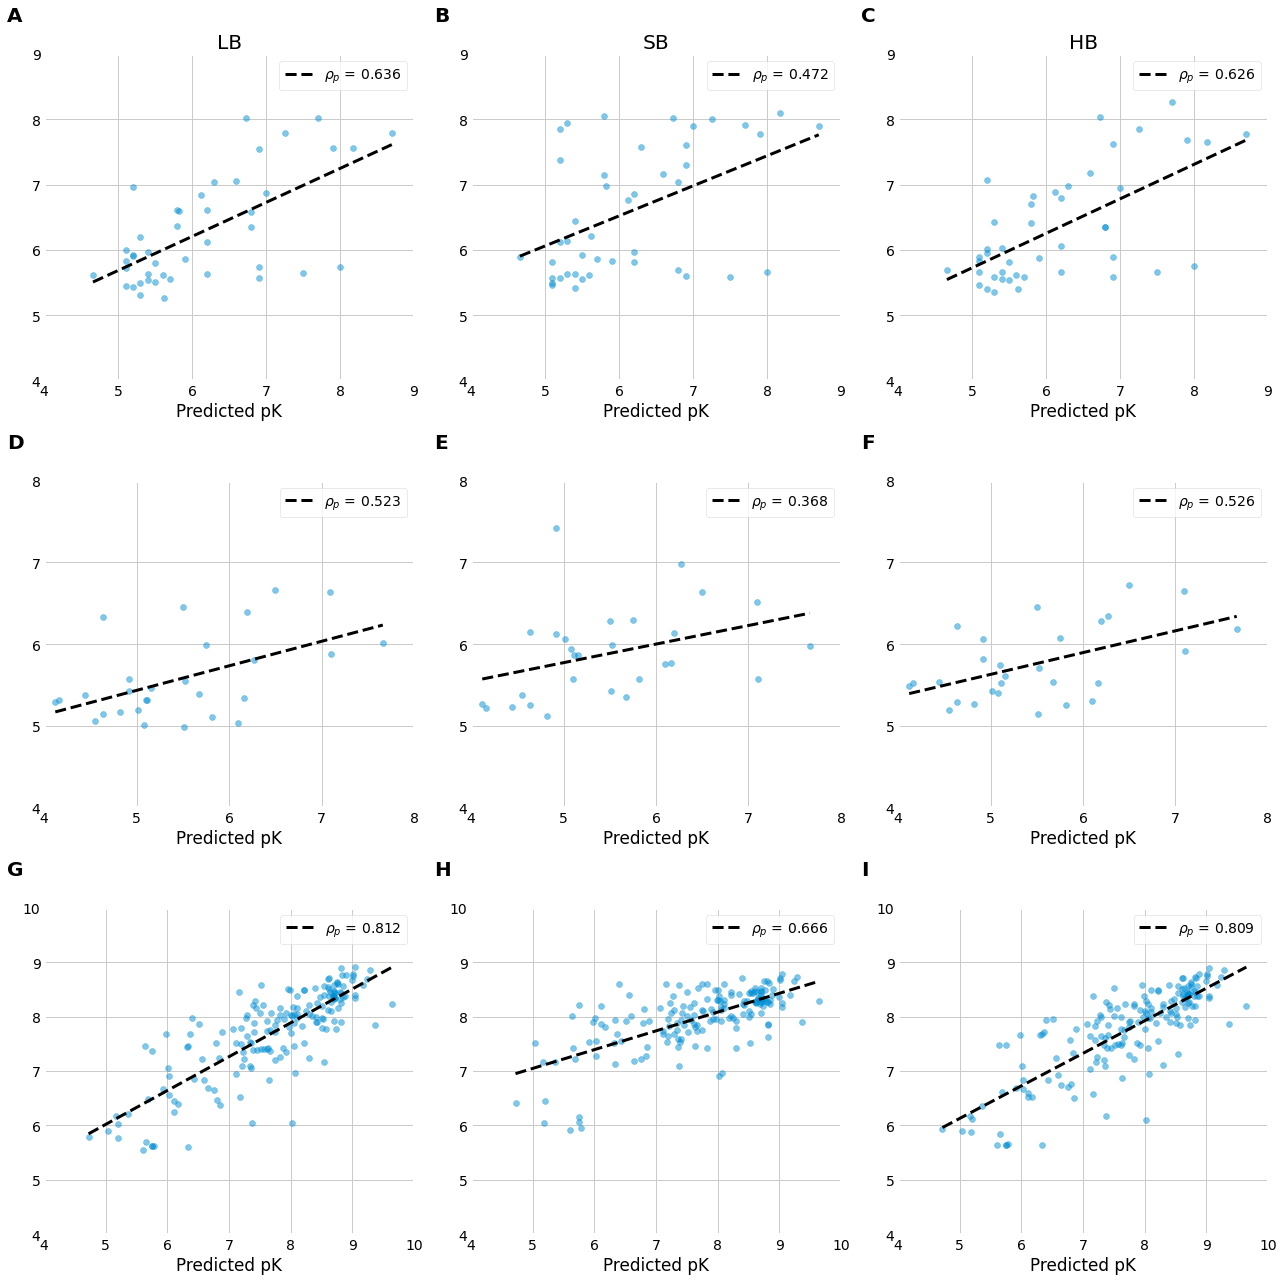

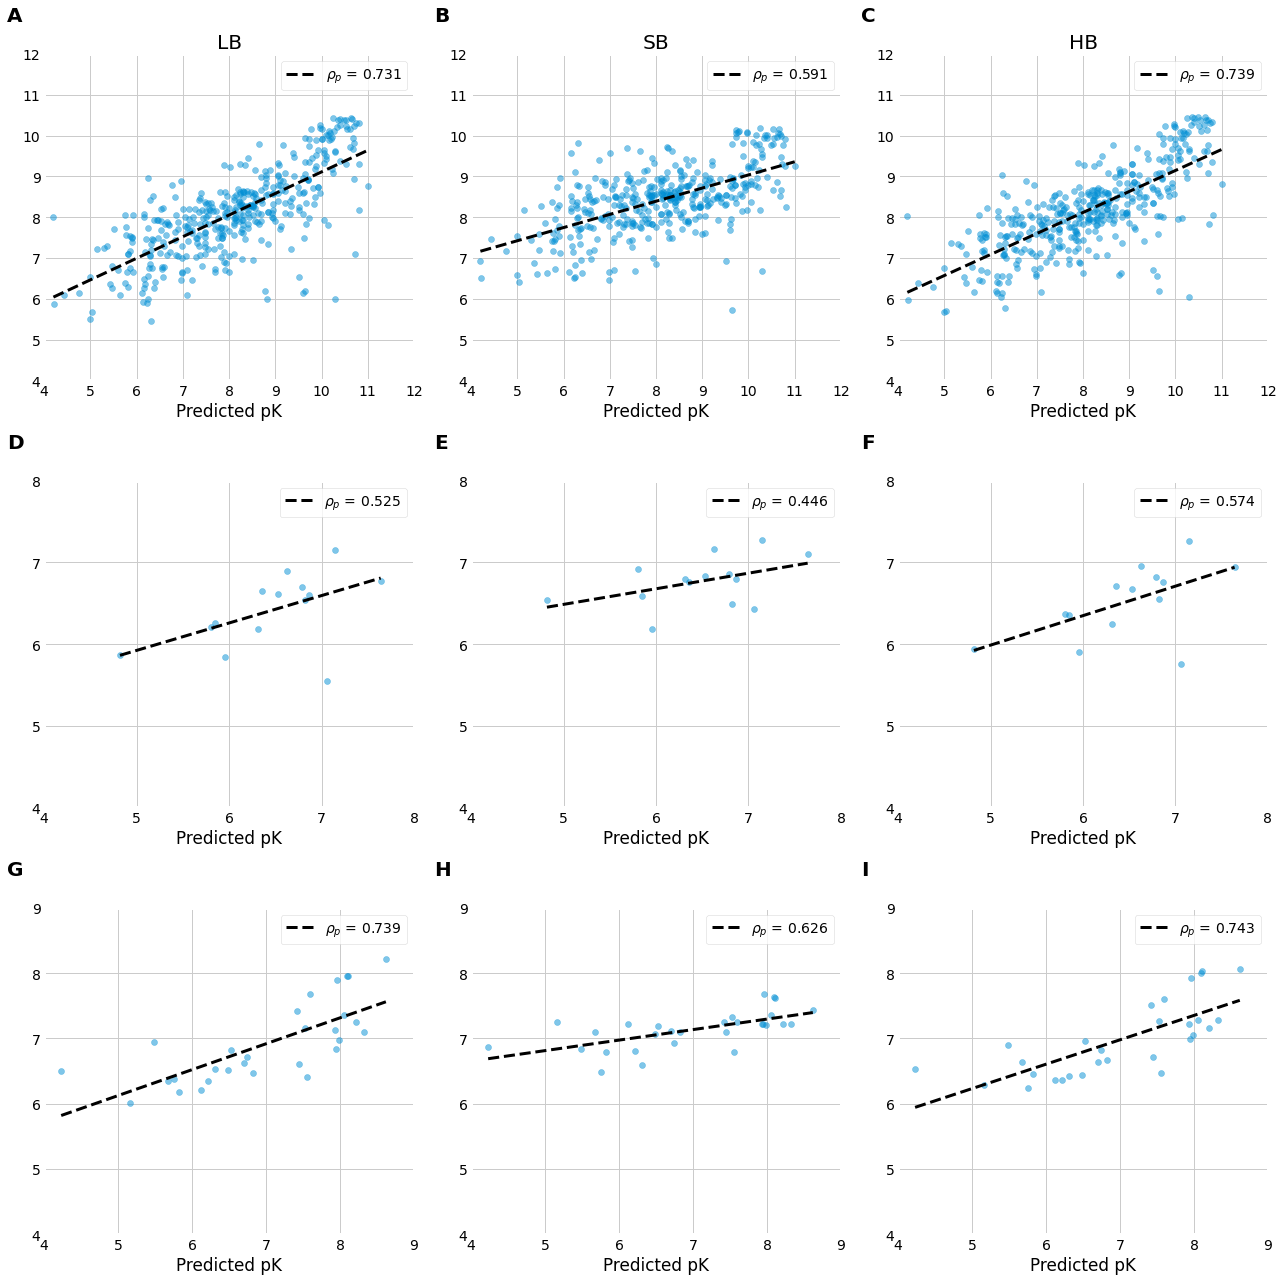

In [15]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[:3], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[intra_target_max_score[target][f].index]
        y_pred = intra_target_max_score[target][f]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel('Measured pK')
        ax.set_xlabel('Predicted pK')
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)

fig.tight_layout()
fig.savefig('../figures/dude_chembl_intra_target_1.png', dpi=350, bbox_inches='tight')

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
for row, target, annots in zip(axes, targets[3:], annotations):
    for ax, f, annot in zip(row, feature_sets, annots):
        y_true = dude_pk[target].loc[intra_target_max_score[target][f].index]
        y_pred = intra_target_max_score[target][f]
        rp = stats.pearsonr(y_true, y_pred)[0]
        ax.scatter(y_true, y_pred, alpha=0.5)
        sns.regplot(y_true, y_pred, scatter=False, ax=ax, ci=False, label=r'$\rho_{p}$' + f' = {rp:.3f}', line_kws={'color': 'k', 'linestyle': '--', 'linewidth': 3})
        ax.set_xticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_yticks(np.arange(int(min(y_true)), int(max(y_true))+2, 1))
        ax.set_xlabel('Measured pK')
        ax.set_xlabel('Predicted pK')
        ax.legend(loc='upper right')
        ax.text(-0.1, 1.1, annot, transform=ax.transAxes, size=20, weight='bold')

for ax, f in zip(axes[0], feature_sets):
    ax.set_title(f)

fig.tight_layout()
fig.savefig('../figures/dude_chembl_intra_target_2.png', dpi=350, bbox_inches='tight')